<h1>Two Sigma Kaggle competition</h1>

<p>I would like to present my solution to competition "Two Sigma Connect: Rental Listing Inquiries" from Kaggle https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries.</p>
<p>The aim of competition was to predict probability that interest in rental listings will reach certain level. The intrest level was expressed as cathegorical variable with three possible values: "low", "medium" and "high". The data were following:</p>

In [ ]:
%matplotlib inline
import matplotlib.cm as cm
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
test = pd.read_json('test.json')
train = pd.read_json('train.json')
train.info()


<p>Data columns (total 15 columns):</p>
<ul>
<li>bathrooms          49352 non-null float64</li>
<li>bedrooms           49352 non-null int64</li>
<li>building_id        49352 non-null object</li>
<li>created            49352 non-null object</li>
<li>description        49352 non-null object</li>
<li>display_address    49352 non-null object</li>
<li>features           49352 non-null object</li>
<li>interest_level     49352 non-null object</li>
<li>latitude           49352 non-null float64</li>
<li>listing_id         49352 non-null int64</li>
<li>longitude          49352 non-null float64</li>
<li>manager_id         49352 non-null object</li>
<li>photos             49352 non-null object</li>
<li>price              49352 non-null int64</li>
<li>street_address     49352 non-null object</li>
</ul>


<h2>Feature selection</h2>

All the features and the way in which they were employed in the final model will be discussed here.

<h3>Interest level</h2>

Interest level is variable which is going to be predicted by the model. In order to use Xgboost algorithm for prediction, the text cathegorical values were converted to numbers. Classes are imbalanced, so weighted f1 score will be used for model evaluationn instead of accuracy. 

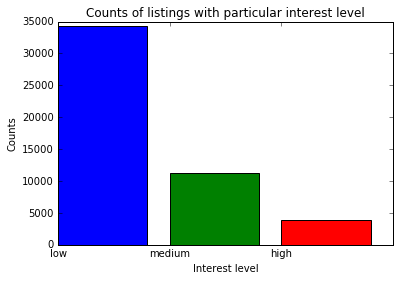

In [123]:
#transform values of interest levels
result = train['interest_level'].copy()
x, y = [0,1,2], ["low","medium","high"] 
result =result.map( dict( zip( y, x)) ).astype(int)
counts = result.groupby(result).count()
#plot counts of interest levels in train data
plt.bar(x, counts, color=["blue", "green", "red"])
plt.xticks(x, ['low','medium','high'])
plt.xlabel('Interest level')
plt.ylabel('Counts')
plt.title('Counts of listings with particular interest level')

<h3/>Bathrooms and bedrooms<h3>

Number of bathrooms and bedrooms were used as features as well as price per bathroom and price per bathroom.

In [124]:
#get number of listings with particular interest level for different number of bathrooms
bathrooms_no_cat_train = train.groupby(['bathrooms', 'interest_level'])['interest_level'].count()
#transform data to data frame, so that they can be displayed in a table
bathrooms_no_cat_train = pd.Series.to_frame(bathrooms_no_cat_train)
bathrooms_no_cat_train.index.names = ['no of bathrooms' , 'interest level']
bathrooms_no_cat_train.columns = ['no of listings']
#get number of listings with particular interest level for different number of bedrooms
bedrooms_no_cat_train = train.groupby(['bedrooms', 'interest_level'])['interest_level'].count()
#transform data to data frame, so that they can be displayed in a table
bedrooms_no_cat_train = pd.Series.to_frame(bedrooms_no_cat_train)
bedrooms_no_cat_train.index.names = ['no of bedrooms' , 'interest level']
bedrooms_no_cat_train.columns = ['no of listings']
#display tables
display(bathrooms_no_cat_train.head(15))
HTML(bedrooms_no_cat_train.head(15).to_html())

no of listings
no of bathrooms interest level                
0.0             high                         1
                low                        306
                medium                       6
1.0             high                      3413
                low                      26581
                medium                    9428
1.5             low                        605
                medium                      40
2.0             high                       407
                low                       5566
                medium                    1687
2.5             low                        274
                medium                       3
3.0             high                        14
                low                        671

As can be expected, most of flats have one bathroom, some have two. Other numbers of bathrooms are rare. As decision trees should be robust to outliners - and any sensitivity was not really observed - no treatment of outliners was adopted.

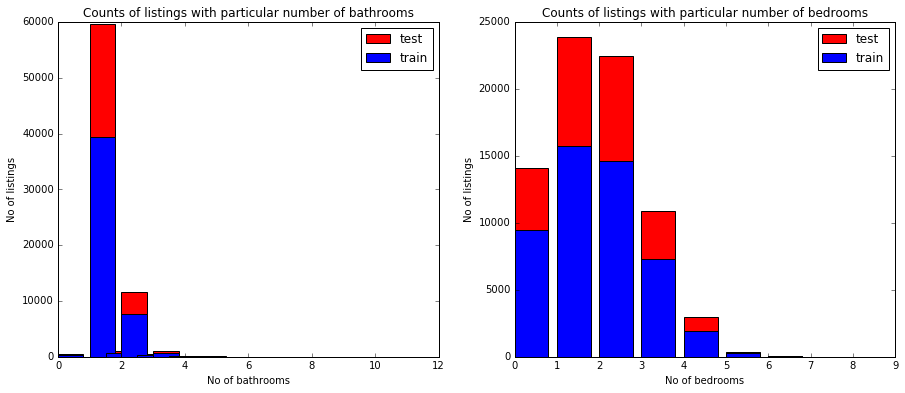

In [125]:
#counts of listing for flates with different numbers of bathrooms
bathrooms_no_train = train.groupby(['bathrooms'])['bathrooms'].count()
bathrooms_no_test = test.groupby(['bathrooms'])['bathrooms'].count()
#counts of listing for flates with different numbers of bedrooms
bedrooms_no_train = train.groupby(['bedrooms'])['bedrooms'].count()
bedrooms_no_test = test.groupby(['bedrooms'])['bedrooms'].count()
#plot counts of listing for flates with different numbers of bathrooms
fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(15, 6))
ax1.bar(bathrooms_no_test.index[:-2], bathrooms_no_test.iloc[:-2], color = "red" )
ax1.bar(bathrooms_no_train.index, bathrooms_no_train, color = "blue" )
ax1.legend(["test", "train"])
ax1.set_xlabel('No of bathrooms')
ax1.set_ylabel('No of listings')
ax1.set_title('Counts of listings with particular number of bathrooms')
#plot counts of listing for flates with different numbers of bedrooms
bedrooms_no_train = train.groupby(['bedrooms'])['bedrooms'].count()
bedrooms_no_test = test.groupby(['bedrooms'])['bedrooms'].count()
ax2.bar(bedrooms_no_test.index, bedrooms_no_test, color = "red" )
ax2.bar(bedrooms_no_train.index, bedrooms_no_train, color = "blue" )
ax2.legend(["test", "train"])
ax2.set_xlabel('No of bedrooms')
ax2.set_ylabel('No of listings')
ax2.set_title('Counts of listings with particular number of bedrooms')

<h3>Manager ID, Listing ID, Building ID</h3>

<p>Manager IDs and Building IDs proved to have strong relation to interest level. At first, new features which contained numbers of listings which belonged to a paricular manager and had specific interest level were created. Althrough prediction with those features performed well when evaluated on validation data, with unknown data from Kaggle the model revealed to be highly overfitted. Thus, eventually, only numbers of listings belonging to a particular manager were used as a feature. Building IDs were treated in the same way as manager IDs.</p>

<p>Listing ID is number which has relation to date of creation. It was used as a feature without any modification.</p>


<h3>Latitude, Longitude</h3>

<p>Latitude and longitude were used without any modification. At first, latitudes and longitudes tried to be grouped to locations with similar levels of interest, but decision tree proved to find boundaries properly. Data relate to listings from New York - locations of flats from listings are depicted in figures below.</p>

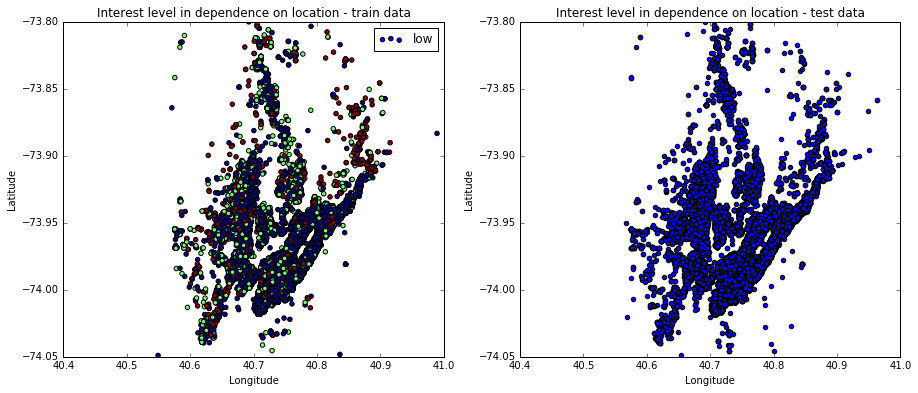

In [155]:
fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(15, 6))
#interest level in depenence of location
ax1.scatter(train['latitude'].values,train['longitude'].values,s=20,c=result.values, marker = 'o', cmap = cm.jet)
ax1.set_xlim([40.4,41])
ax1.set_ylim([-74.05,-73.8])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend(["low","medium","high"])
ax1.set_title('Interest level in dependence on location - train data')
#locations in test data
ax2.scatter(test['latitude'].values,test['longitude'].values,s=20, marker = 'o', cmap = cm.jet  )
ax2.set_xlim([40.4,41])
ax2.set_ylim([-74.05,-73.8])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Interest level in dependence on location - test data')

<h3>Price</h3>

Price and log(price) were used in model.

<h3>Photos</h3>

Number of photos was used in model.

<h3>Description and features</h3>

<p>Description and features were treated in the same way. They were tranformed to a matrix of token counts. Chi^2 test was performed to select 200 words which best characterize result vector. Then, training set created by those counts of words was splitted to five parts. Four fifths of the data were used to predict interest level of the fifth part of data. Algorithm used for this prediction was SVC. Parameters of SVC were found by means of grid search. Prediction was repeated for all parts of splitted data and predicted interest level was used as new feature in final prediction. The code can be found in predict-from-description.py and predict-from-feature.py file.</p>


<h3>Date of creation</h3>

It was expected that older listings would collect more views, but it does not seem to be correct. Nevertheless, age of listing in days was used in model.

In [156]:
#number of days between day when the listing was created and the oldest listing - train data
train['train_created']  = pd.to_datetime(train["created"])
min_created_train = min(train['train_created'])
train['train_created'] = train['train_created'].apply(lambda x: x-min_created_train)
train['train_created'] = train['train_created'].apply(lambda x: x.days)
created_dat_cat_no = train.groupby(['train_created', "interest_level"])["interest_level"].count()
#transform data to data frame, so that they can be displayed in a table
created_dat_cat_no = pd.Series.to_frame(created_dat_cat_no)
created_dat_cat_no.index.names = ['age of listing in days' , 'interest level']
created_dat_cat_no.columns = ['no of listings']
display(created_dat_cat_no)
#number of days between day when the listing was created and the oldest listing - test data
test['train_created'] = pd.to_datetime(test["created"])
min_created_test = min(test['train_created'])
test['train_created']  = test['train_created'].apply(lambda x: x-min_created_train)

no of listings
age of listing in days interest level                
0                      high                        54
                       low                        447
                       medium                     162
1                      high                        16
                       low                        234
                       medium                      60
2                      high                        32
                       low                        233
                       medium                      80
3                      high                        59
                       low                        397
                       medium                     145
4                      high                        81
                       low                        667
                       medium                     186
5                      high                        72
                       low                        416
                       medium                     133
6                      high                        49
                       low                        388
                       medium                     156
7                      high                        31
                       low                        409
                       medium                     123
8                      high                        26
                       low                        284
                       medium                      80
9                      high                        29
                       low                        228
                       medium                      70
...                                               ...
79                     high                        26
                       low                        289
                       medium                      88
80                     high                        80
                       low                        876
                       medium                     232
81                     high                        57
                       low                        485
                       medium                     140
82                     high                        21
                       low                        342
                       medium                      74
83                     high                        56
                       low                        510
                       medium                     159
84                     high                        46
                       low                        380
                       medium                     122
85                     high                        12
                       low                        196
                       medium                      60
86                     high                        16
                       low                        237
                       medium                      70
87                     high                        34
                       low                        451
                       medium                     145
88                     high                        56
                       low                        575
                       medium                     161

[262 rows x 1 columns]

<h2>Algorithm</h2>

<p>XGboost algorithm using data described above was employed to predict probability that a listing will reach certain interest level. Parameters of model were found by means of grid search. The final parameters were:</p>
<ul>
<li>max_delta_step=1</li>
<li>objective='multi:softprob'</li>
<li>learning_rate = 0.01</li>
<li>n_estimators=3000</li>
<li>reg_lambda = 1</li>
<li>max_depth = 8</li>
<li>subsample = 0.7</li>
<li>colsample_bytree = 0.7 </li> 
</ul>

<h2>Conclusion</h2>

The model was placed in the competition at 1653rd (of 2488) place. There are several steps which could be taken to improve performance of the model:
- combine models of different types - ensemble learning reduces both bias and overfitting, it is most common strategy employed in Kaggle
- more feature engineering, according to other Kagglers reports, successful models used more than 100 features
- selection of model is very time consuming, cloud computing services would help
- competition has already finished and competitors are sharing their approaches on Kaggle which will be inspiring reading :-)